In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_303024/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#core data lib
import pandas as pd
import pandasql as ps

In [3]:
#https://ourworldindata.org/
#https://github.com/owid/covid-19-data/tree/master/public/data/
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [4]:
df.head(4) #continent

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
df = df.sort_values(by=['date'])
df = df.reset_index()

#datetime to int(Epoch)
df['date'] = pd.to_datetime(df['date'])
df['date'] = (pd.to_numeric(df['date'])/1000000000).astype(int)

#text to string
df['continent'] = df['continent'].astype(str)
df['location'] = df['location'].astype(str)

#NaN to 0
df['new_cases'] = df['new_cases'].fillna(0)

In [6]:
df2 = ps.sqldf('''
                select *
                from 
                (select date, continent, location, life_expectancy, human_development_index, female_smokers+male_smokers smokers,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING) cases7,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING) cases14,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21 PRECEDING AND 1 PRECEDING) cases21,
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64 PRECEDING AND 1 PRECEDING) cases64,

                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 128 PRECEDING AND 1 PRECEDING) cases_128_1,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING) / 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING) perc_7to14,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21 PRECEDING AND 1 PRECEDING) / 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING) perc_7to21,
                
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64 PRECEDING AND 1 PRECEDING) / 
                sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING) perc_7to64,
                
                new_cases
                from df
                where continent is not null and continent !='nan' and total_cases>0 and location='Russia'
                order by date, new_cases
                ) a
                where cases_128_1 >0
                ''')
#where total_cases>0 and location='Russia'

In [7]:
df2.tail(8)
#332584

,date,continent,location,life_expectancy,human_development_index,smokers,cases7,cases14,cases21,cases64,cases_128_1,perc_7to14,perc_7to21,perc_7to64,new_cases
947,1662336000,Europe,Russia,72.58,0.824,81.7,318626.0,602895.0,834843.0,1274524.0,1532203.0,1.892171,2.620135,4.000063,41040.0
948,1662422400,Europe,Russia,72.58,0.824,81.7,320783.0,611466.0,851002.0,1312511.0,1565976.0,1.906167,2.652890,4.091585,38023.0
949,1662508800,Europe,Russia,72.58,0.824,81.7,322327.0,619062.0,865536.0,1347710.0,1597045.0,1.920602,2.685273,4.181189,47354.0
950,1662595200,Europe,Russia,72.58,0.824,81.7,323897.0,626727.0,880128.0,1392412.0,1638277.0,1.934958,2.717308,4.298935,49884.0
951,1662681600,Europe,Russia,72.58,0.824,81.7,324765.0,633254.0,894697.0,1439174.0,1682787.0,1.949884,2.754906,4.431432,51420.0
952,1662768000,Europe,Russia,72.58,0.824,81.7,325906.0,638882.0,909086.0,1487270.0,1729183.0,1.960326,2.789412,4.563494,52708.0
953,1662854400,Europe,Russia,72.58,0.824,81.7,327692.0,645188.0,922376.0,1536561.0,1776939.0,1.968885,2.814765,4.689040,52155.0
954,1662940800,Europe,Russia,72.58,0.824,81.7,332584.0,651210.0,935479.0,1585212.0,1823646.0,1.958032,2.812760,4.766351,45911.0


In [8]:
#from sklearn.model_selection import train_test_split
#df_valid, df_test = train_test_split(df2, test_size=0.2)

df_train=df2.sample(frac=0.95, random_state=20220912) #random state is a seed value
df_valid=df2.drop(df_train.index)


# Initialize data
cat_features = [0, 1]

#train
Y_train = df_train['new_cases'] #df2['new_cases'].head(int(len(df2.index)*0.9))
X_train = df_train.drop(['new_cases', 'date'], axis=1) #df2.drop(['new_cases', 'date'], axis=1).head(int(len(df2.index)*0.9))

from catboost import Pool
train_pool= Pool(X_train, Y_train, cat_features)

#validation
Y_valid = df_valid['new_cases'] #df2['new_cases'].tail(int(len(df2.index)*0.1))
X_valid = df_valid.drop(['new_cases', 'date'], axis=1) #df2.drop(['new_cases', 'date'], axis=1).tail(int(len(df2.index)*0.1))


In [9]:
#import catboost
from catboost import CatBoostRegressor

#limits
limit_iterations = 20000
limit_metric_period = int(limit_iterations/50)
limit_early_stopping_rounds = int(limit_iterations*0.3)


# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=limit_iterations,
                          #learning_rate=0.1,
                          depth=10,
                          #task_type="GPU",
                          #devices='0:1'
                          thread_count = 16,
                          loss_function="RMSE",
                          eval_metric="RMSE",
                          #остановка переобучения после нахождения оптимального дерева
                          early_stopping_rounds=limit_early_stopping_rounds
                         )
# Fit model
model.fit(train_pool, eval_set=(X_valid, Y_valid), metric_period=limit_metric_period) #, plot='true'


Learning rate set to 0.008065
0:	learn: 28692.0303135	test: 29424.5366186	best: 29424.5366186 (0)	total: 69ms	remaining: 23m


400:	learn: 3139.2928019	test: 4671.5520969	best: 4671.5520969 (400)	total: 5.7s	remaining: 4m 38s
800:	learn: 1326.4020597	test: 2518.3965533	best: 2518.3965533 (800)	total: 11.3s	remaining: 4m 31s
1200:	learn: 988.7846191	test: 2130.5721775	best: 2130.5721775 (1200)	total: 17s	remaining: 4m 25s
1600:	learn: 826.4528616	test: 2125.1931127	best: 2113.9754478 (1267)	total: 22.6s	remaining: 4m 19s
2000:	learn: 708.5136738	test: 2100.7147005	best: 2100.7147005 (2000)	total: 28.2s	remaining: 4m 13s
2400:	learn: 617.7517265	test: 2077.2182173	best: 2077.1989384 (2399)	total: 33.8s	remaining: 4m 7s
2800:	learn: 554.9423750	test: 2066.0182363	best: 2065.9528277 (2797)	total: 39.3s	remaining: 4m 1s
3200:	learn: 502.0027771	test: 2059.1923241	best: 2059.1923241 (3200)	total: 44.9s	remaining: 3m 55s
3600:	learn: 459.1793478	test: 2050.4708890	best: 2050.2916337 (3592)	total: 50.4s	remaining: 3m 49s
4000:	learn: 420.2965193	test: 2042.2097586	best: 2042.2097586 (4000)	total: 56s	remaining: 3m 43s

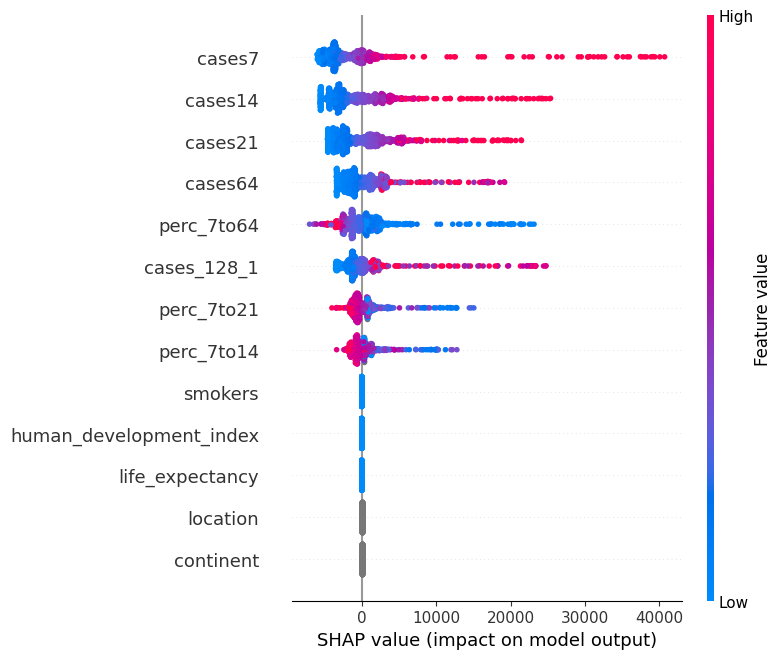

In [10]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)

shap.summary_plot(shap_values, X_train)

In [11]:
#shap.summary_plot(shap_values, X_train, plot_type="bar")

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[0:600,:], X_train.iloc[0:600,:])

In [17]:
#цикл
i=0
while i < 180:
    i = i + 1

    #данные для предсказания
    df_predict = ps.sqldf('''
                    select *
                    from
                    (select date as date, continent, location, life_expectancy, human_development_index, smokers,
                    
                     sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7-1 PRECEDING AND 1-1 PRECEDING) cases7,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14-1 PRECEDING AND 1-1 PRECEDING) cases14,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21-1 PRECEDING AND 1-1 PRECEDING) cases21,
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64-1 PRECEDING AND 1-1 PRECEDING) cases64,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 128-1 PRECEDING AND 1-1 PRECEDING) cases_128_1,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 14-1 PRECEDING AND 1-1 PRECEDING) / 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7-1 PRECEDING AND 1-1 PRECEDING) perc_7to14,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 21-1 PRECEDING AND 1-1 PRECEDING) / 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7-1 PRECEDING AND 1-1 PRECEDING) perc_7to21,

                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 64-1 PRECEDING AND 1-1 PRECEDING) / 
                    sum(new_cases) over (PARTITION BY continent, location ORDER BY date ROWS BETWEEN 7-1 PRECEDING AND 1-1 PRECEDING) perc_7to64
                
                    from df2
                    order by date, new_cases) a
                    where date=(select max(date) from df2)
                        and location='Russia'
                    ''')
    df_predict

    #предсказание
    preds = model.predict(df_predict.loc[:, df_predict.columns !='date'], thread_count = 16)
    #preds

    #возвращаем рассчитанные значения
    df_new_row = df_predict
    df_new_row = df_new_row.join(pd.DataFrame(preds))
    df_new_row.rename(columns={0: 'new_cases'}, inplace=True)
    df_new_row['date'] = df_new_row['date']+86400
    df_new_row['new_cases'] = df_new_row['new_cases'].astype(int)
    #df_new_row

    #возвращает данные в основной массив
    df2 = pd.concat([df2, df_new_row], axis=0, ignore_index=True)
    #df2

#df2.tail(10)

In [18]:
import plotly.express as px

#df2['date'] = pd.to_datetime(df2['date'])

df2graphe = ps.sqldf('''select * from df2 where location='Russia' order by date, new_cases ''')
df2graphe['date'] = pd.to_datetime(df2graphe['date'],unit='s')

fig = px.line(df2graphe, x="date", y="new_cases", title='covid stats')
fig.show()

In [14]:
#shap.force_plot(explainer.expected_value, shap_values[6000,:], X_train.iloc[6000,:])